# Analyzing NYC High School Data
One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests and whether they're unfair to certain groups. I'll investigate the correlations between SAT scores and demographics might be an interesting angle to take.
## Preparetion of the data
New York City makes its data on high school SAT scores available online, as well as the demographics for each high school. 

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

#### Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

Explanation of data
- ap_2010.csv - Data on AP test results
- class_size.csv - Data on class size
- demographics.csv - Data on demographics
- graduation.csv - Data on graduation outcomes
- hs_directory.csv - A directory of high schools
- sat_results.csv - Data on SAT scores
- survey_all.txt - Data on surveys from all schools
- survey_d75.txt - Data on surveys from New York City district 75

## Cleaning the data
#### Add DBN columns
DBN is the school identification. The DBN column is useful to combine them.

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

#### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#### Condense datasets
Focusing on the data which this analysis will use.

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

#### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

#### Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

#### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

#### Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


#### Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

## What does the matter that affects the total score?

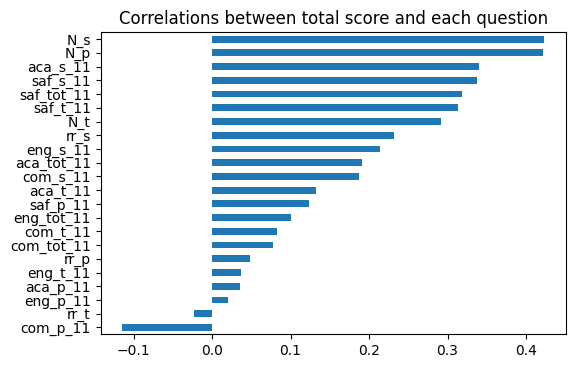

In [11]:
correlations[survey_fields].sort_values().plot.barh(title='Correlations between total score and each question')


### Observation
The following chart is the explanation of each survey. The 'saf_t_11' and 'saf_s_11', which measure how teachers and students perceive safety at school, correlated highly with sat_score.

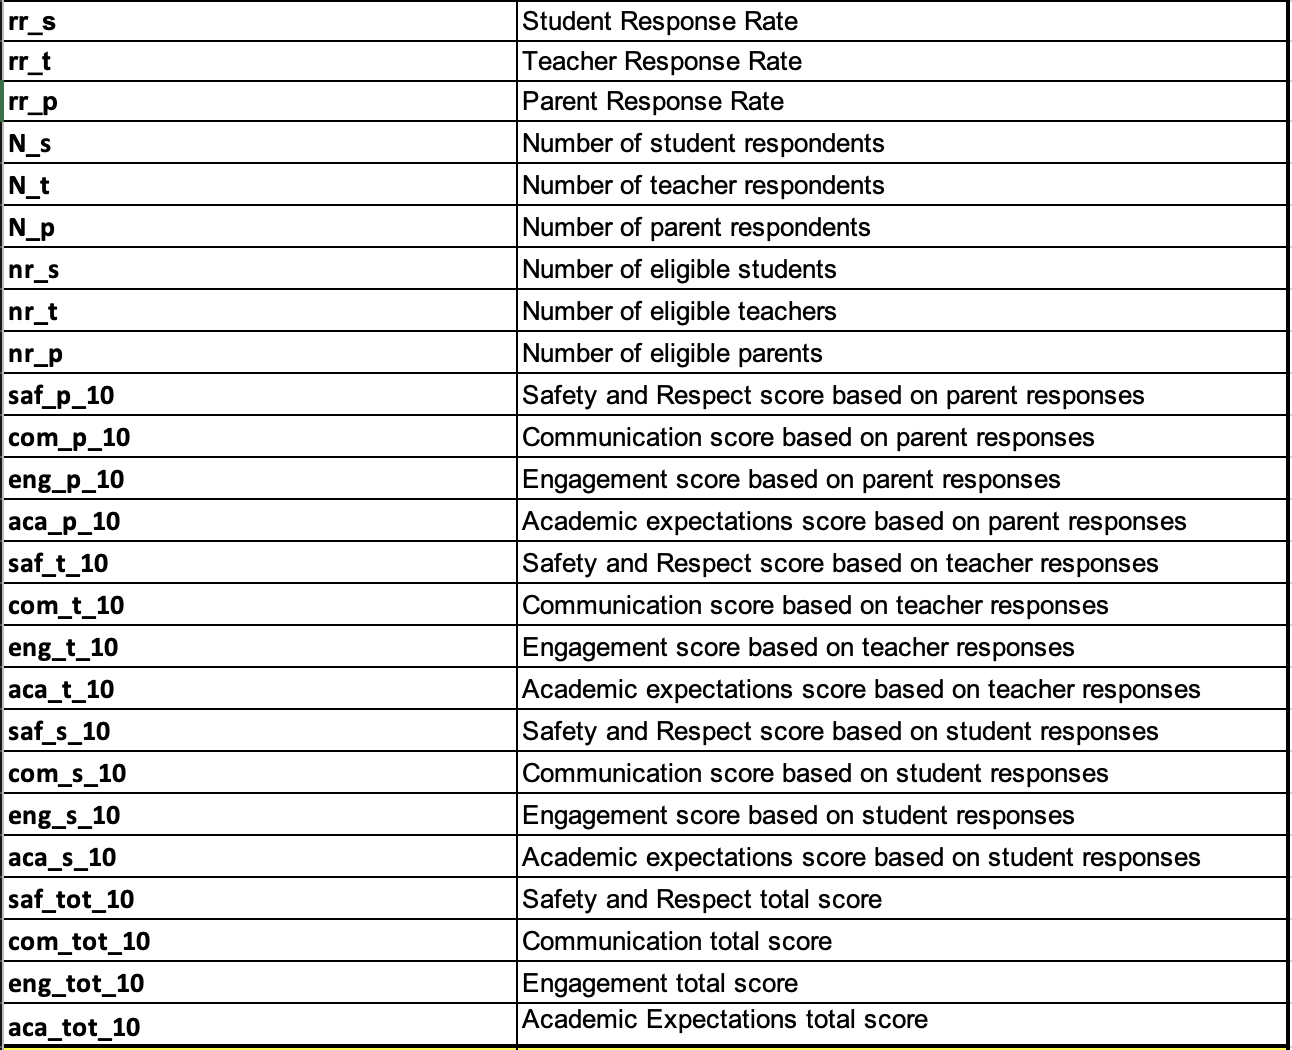

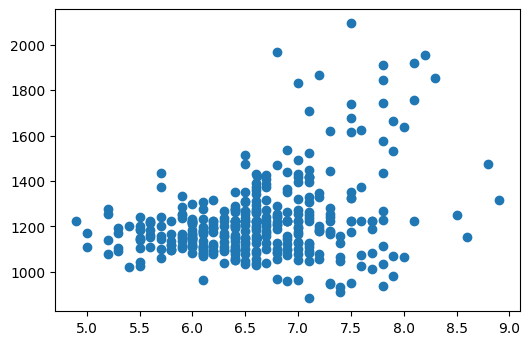

In [12]:
plt.scatter(x=combined['saf_s_11'], y=combined['sat_score'])

### Observation
The 'Safety Score' has a weak positive relationship with the 'Sat Score'.

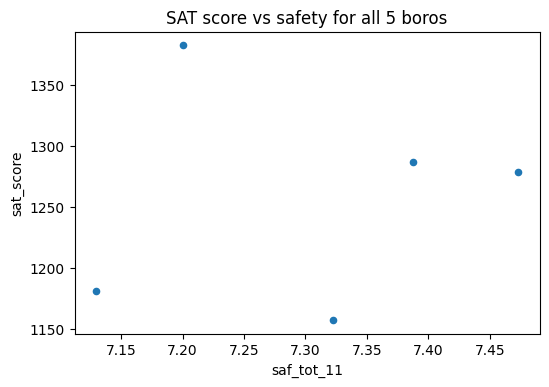

In [13]:
safety_per_borough = combined[['boro', 'sat_score', 'saf_tot_11']].groupby('boro').agg(np.mean).reset_index()
safety_per_borough.plot(kind = 'scatter', x = 'saf_tot_11', y = 'sat_score', title = 'SAT score vs safety for all 5 boros')
plt.show()

Manhattan and Queens are safe areas, and Brooklyn is not safe. We cannot see a clear correlation between perceived safety and SAT score.

## Analysis on Racial Difference

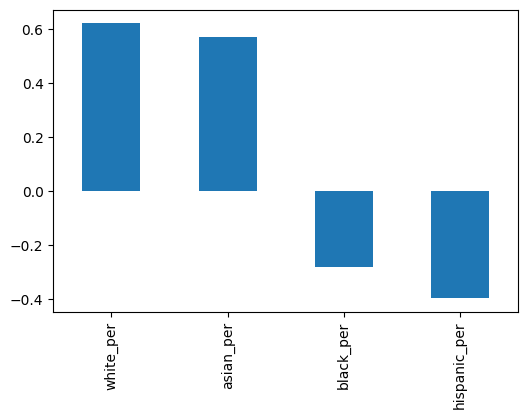

In [14]:
correlations[['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot.bar()

White and Asian have positive relationship with sat score, while Black and Hispanic have negative one.

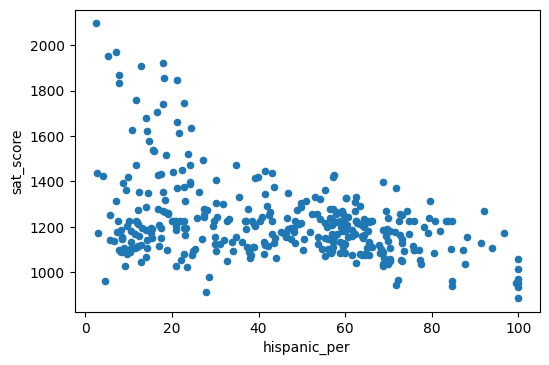

In [17]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

From this scatter plot, we can observe the negative relationship between the percentage of hispanic students and SAT score.

In [27]:
combined[combined['hispanic_per'] > 95][['SCHOOL NAME', 'boro']]

,SCHOOL NAME,boro
44,MANHATTAN BRIDGES HIGH SCHOOL,Manhattan
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,Manhattan
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,Manhattan
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,Bronx
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,Bronx
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,Bronx
253,MULTICULTURAL HIGH SCHOOL,Brooklyn
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,Queens


These are several hispanic schools between Manhattan and Bronx area.

In [45]:
not_hisp_high_sat = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1000)][['SCHOOL NAME', 'boro']]
not_hisp_high_sat['boro'].value_counts() / combined['boro'].value_counts()

Bronx            0.010753
Brooklyn         0.169811
Manhattan        0.022222
Queens           0.093750
Staten Island    0.200000
Name: boro, dtype: float64

In 'Brooklyn' and 'Staten Island' borough, around 20% of schools have hispanic_per less than 10% and average SAT score greater than 1800.

## Analysis on Gender Difference

In [52]:
combined[combined['male_per'] + combined['female_per'] != 100][['male_per', 'female_per']]

,male_per,female_per
118,45.8,54.0
203,47.7,52.2


We can consider that every data has almost 100% with male and female students.

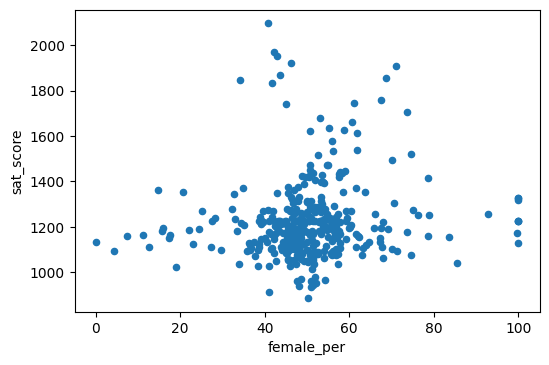

In [53]:
combined.plot.scatter('female_per', 'sat_score')

It seems no relationship between female student percentage and SAT score.

In [63]:
many_female_high_sat = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]\
[['SCHOOL NAME','boro', 'female_per', 'white_per', 'asian_per', 'black_per', 'hispanic_per','sat_score']]
total_means = combined[['SCHOOL NAME','boro', 'female_per', 'white_per', 'asian_per', 'black_per', 'hispanic_per','sat_score']].mean()
many_female_high_sat.mean() / total_means


female_per      1.350832
white_per       5.625130
asian_per       2.291719
black_per       0.295282
hispanic_per    0.372603
sat_score       1.467176
dtype: float64

There are a lot of White and Asian students in the schools that have many females and high sat score.

## Analysis on AP exam takers
In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [66]:
ap_per = combined['AP Test Takers '] / combined['total_enrollment']

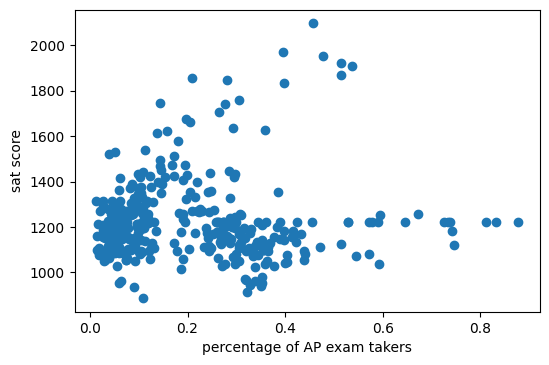

In [71]:
plt.scatter(x=ap_per, y=combined['sat_score'])
plt.xlabel('percentage of AP exam takers')
plt.ylabel('sat score')
plt.show()

There is positive relationship between sat score and percentage of AP exam takers.